In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as T

import os
os.environ["KMP_DUPLICATE_LIB_OK"]='True'   # I've problem with plt and this resolves.
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

from common.dataset import get_dataloader_params
from common.distances import Cosine_distance
from common.evaluation_metrics import pair_ids_with_distance_matrix

from deep.model import ReIDModel

dataset_paths = {}
dataset_paths['motsynth'] = "D:\\Data\\University\\MOTSynth\\dataset_singleclip"
dataset_paths['market1501'] = "D:\\Data\\University\\market-1501"
dataset_paths['mars'] = "D:\\Data\\University\\MARS_dataset_test"


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weights_path = "D:\\Data\\University\\People-Analysis\\ReID\deep\\results\\training10\\model.bin"


In [2]:
model = ReIDModel("resnet50", 1000, True).to(device)
weights = torch.load(weights_path)
model.load_state_dict(weights)
model.eval()

target_dataset='mars'
max_ids = 200
batch_size = 16
trainloader, queryloader, galleryloader = get_dataloader_params(dataset_path=dataset_paths[target_dataset], target_res=(224,224),normalize=False, max_ids_test=max_ids, dataset=target_dataset, batch_size=batch_size)

target_res = (256,128)

resize_transform = T.Compose([
        T.Resize(target_res),
    ])

norm_transform = T.Compose([
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

In [3]:
@torch.no_grad()
def extract_feature(model:nn.Module, dataloader, device):
    model.eval()
    for batch_idx, (imgs, batch_pids) in enumerate(dataloader):
        norm_imgs = norm_transform(imgs.to(device=device))  #images are left in ram (no gpu) for space isssues
        batch_features = model(norm_imgs).data

        batch_pids = torch.Tensor(batch_pids).to(device=device, dtype=torch.int)

        if batch_idx == 0:
            imgs_list = imgs
            norm_features = batch_features
            pids = batch_pids
        else:
            norm_features = torch.cat((norm_features, batch_features),0)
            imgs_list = torch.cat((imgs_list, imgs),0)
            pids = torch.cat((pids, batch_pids), 0)
                
    return imgs_list, norm_features, pids

In [4]:
gellery_imgs, gf, g_pids = extract_feature(model, galleryloader, device)
print(gf.shape)

KeyboardInterrupt: 

In [ ]:
#Re-run me for different queries

(original_probes, pid) = next(iter(queryloader))
probes = resize_transform(original_probes)
probes = torch.permute(probes,(0,2,3,1))
print(probes.shape)

torch.Size([16, 256, 128, 3])


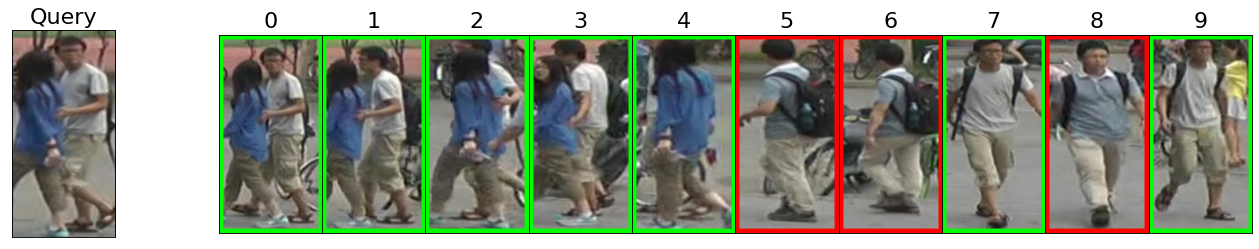

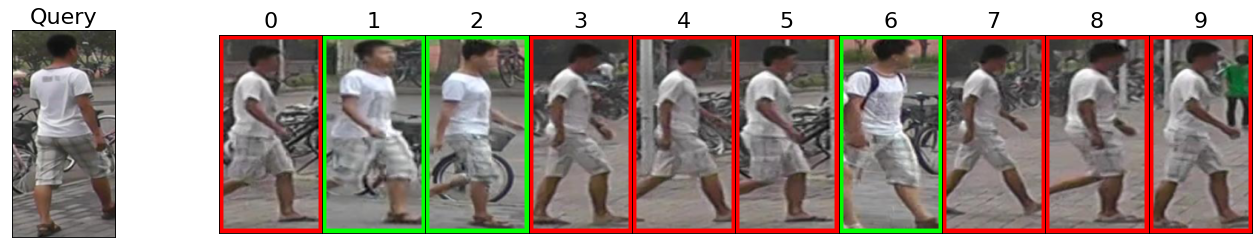

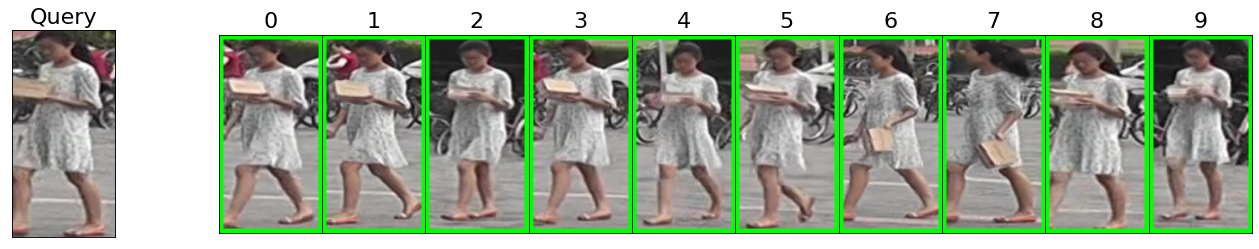

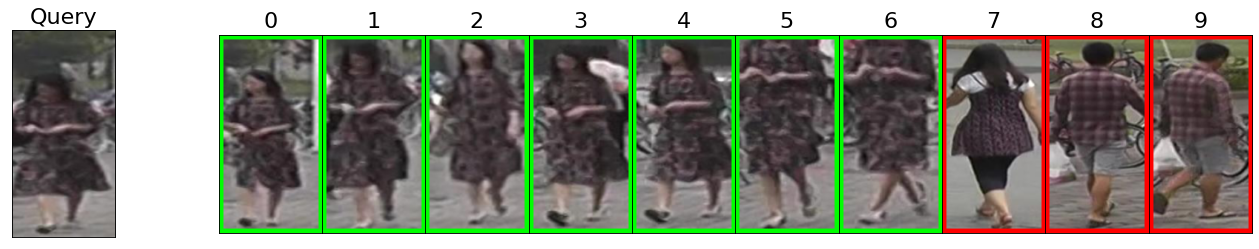

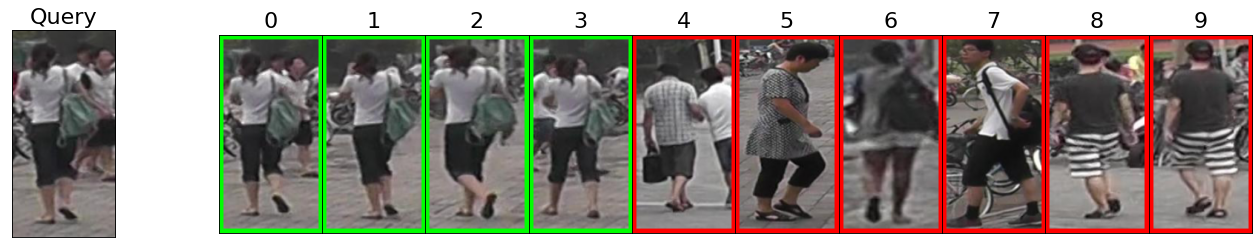

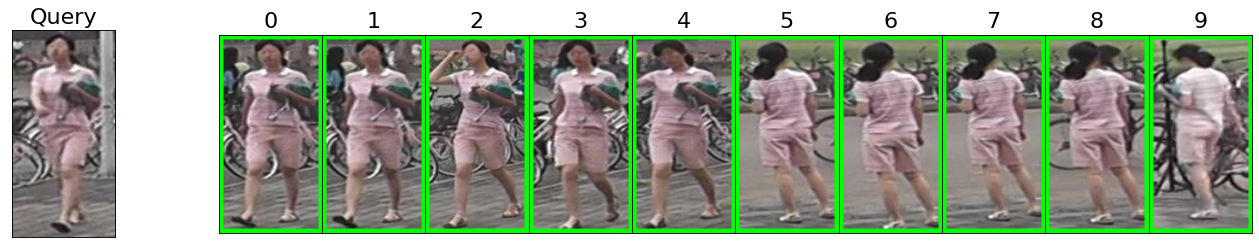

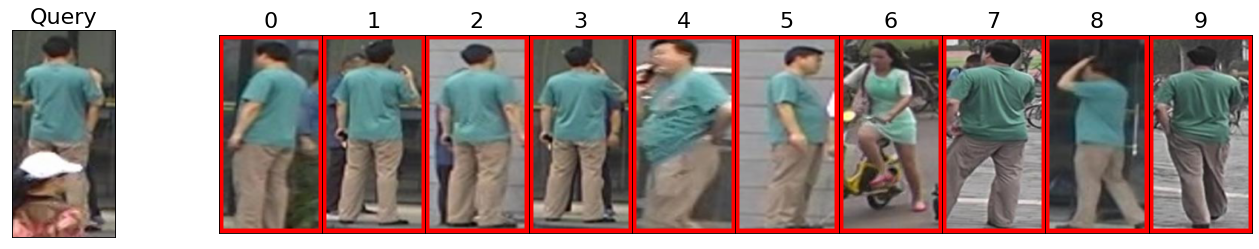

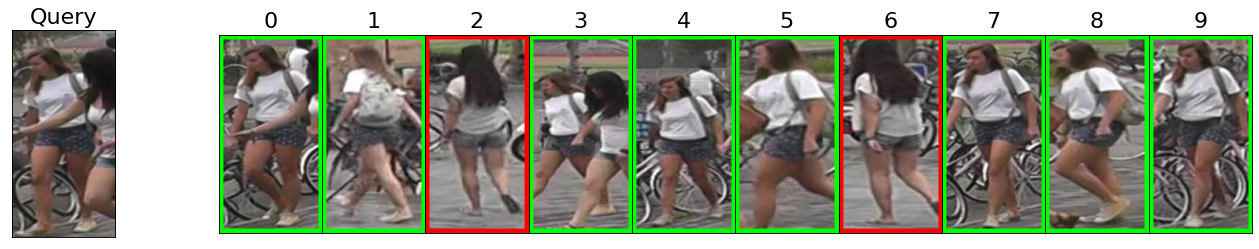

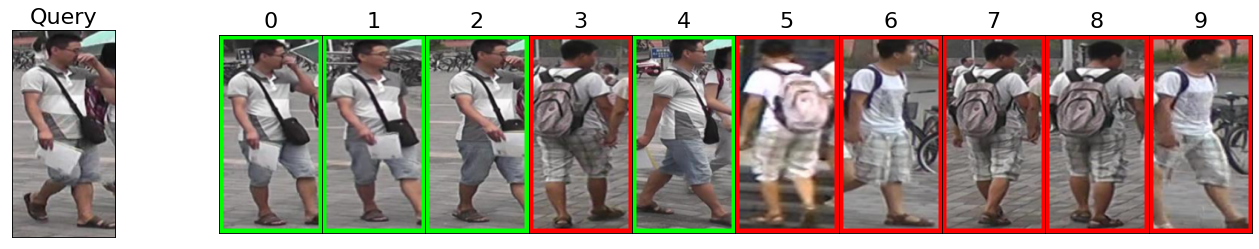

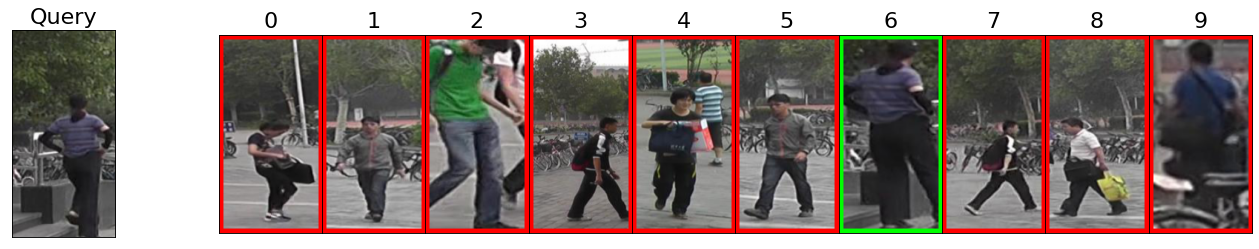

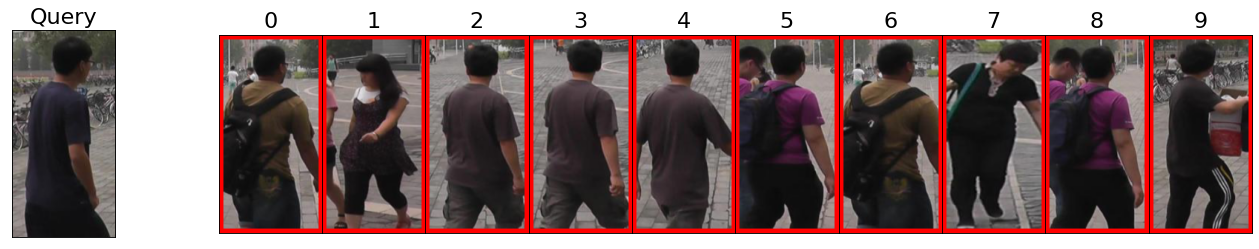

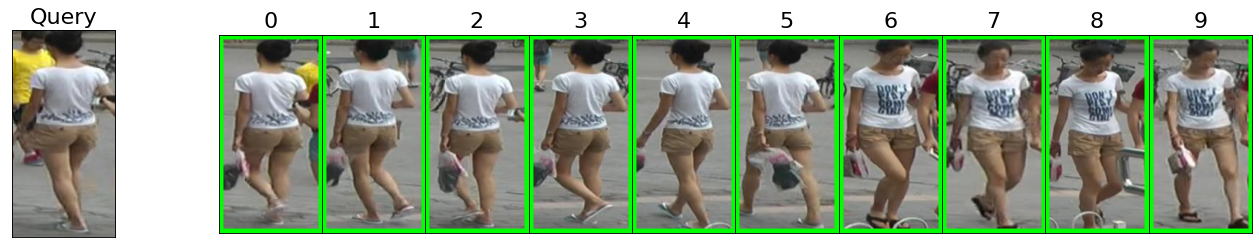

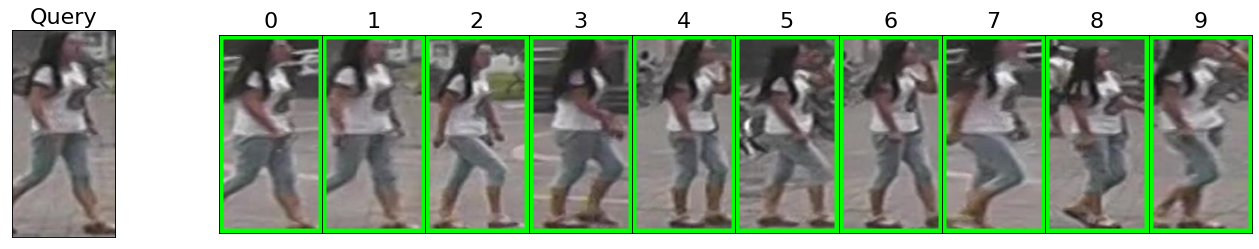

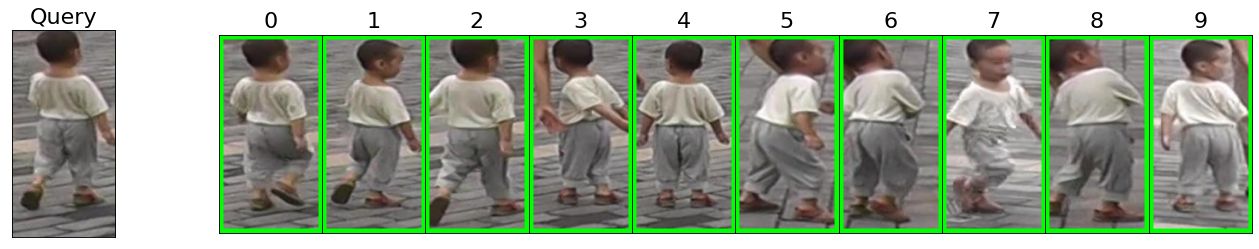

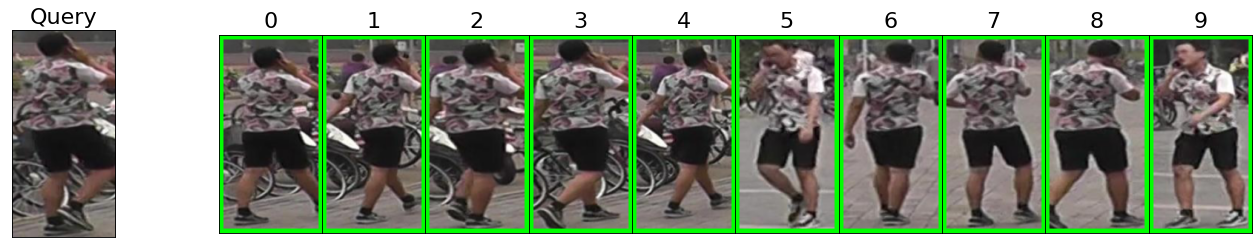

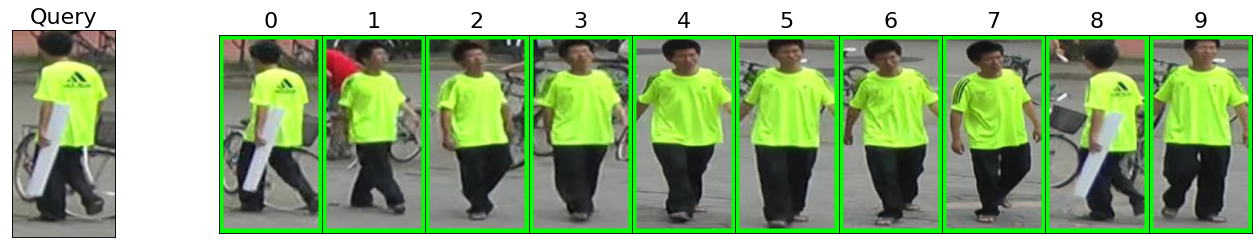

In [ ]:
to_show=10  #how many item from the ranked list to show.


def add_outline(img:torch.Tensor, width:int, color:torch.Tensor):
    result = color.expand((img.shape[0]+2*width, img.shape[1]+2*width, img.shape[2])).clone()
    result[width:-width, width:-width] = img
    return result

for target_idx in range(batch_size):


    query = original_probes[target_idx]
    q_pid = pid[target_idx]

    norm_query = norm_transform(query)
    query = resize_transform(query)

    query = torch.permute(query,(1,2,0))
    norm_query = norm_query.unsqueeze(0)

    qf = norm_query.to(device=device)
    qf = model(qf).data

    distances = Cosine_distance(qf,gf)
    idxs = torch.argsort(distances, dim=-1).flatten()
    idxs = idxs[:to_show]
    calc_ids = torch.zeros_like(idxs, dtype=torch.int, requires_grad=False).to(device)
    closest_imgs = torch.zeros_like(gellery_imgs[:to_show], requires_grad=False)
    idxs_cpu = idxs.cpu()
    for i in range(to_show):
        calc_ids[i] = g_pids.flatten().index_select(-1, idxs[i])
        closest_imgs[i] = gellery_imgs.index_select(0, idxs_cpu[i])

    closest_imgs = resize_transform(closest_imgs)
    closest_imgs = torch.permute(closest_imgs,(0,2,3,1))
    closest_imgs = closest_imgs.cpu()

    color_success = torch.as_tensor(([0.0, 1.0, 0.0]))
    color_fail = torch.as_tensor(([1.0, 0.0, 0.0]))


    #plot
    plt.figure(figsize=(20, 20), dpi=80)
    plt.subplots_adjust(hspace=0.00)

    #make outer gridspec
    grid = gridspec.GridSpec(1, 2+to_show, height_ratios = [2]) 


    probe_ax = plt.subplot(grid[:,0])
    probe_ax.imshow(query)
    probe_ax.set_title("Query", fontsize = 20)
    probe_ax.axes.xaxis.set_visible(False)
    probe_ax.axes.yaxis.set_visible(False)

    for i in range(to_show):
        ax = plt.subplot(grid[:,i+2])
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)

        if calc_ids[i] == pid[target_idx]:
            color = color_success
        else:
            color = color_fail
        img = add_outline(closest_imgs[i], 6, color)
        ax.imshow(img)
        ax.set_title(f"{i}", fontsize = 20)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
